# Advisory report
___
<pre>Teamname    : Submission Impossible 💥  
Group nr    : 32 - Company C  
Students    : {Andrei Dragomir, Ece Doganer, Márk Kerekes, Ariana Vargas Pastor}  
Student nrs : {2669304,         2552855,     2696796,      2710153}  </pre>
___

#### Structure of the project:
1. Data Exploration:
- Data visualisation;
- Comparisons of our company's hiree distributions as opposed to those of the other companies;
- Hiree descriptive data distributions (based on gender, age, nationality and sports) compared to the distributions of all applicants for company C;
- Hiree indicative data distributions compared to the distributions of all applicants for company C;
- Data processing and cleaning.

2. Modelling:
- Model M1: Neural Network with single hidden layer and no drop-out
    - Only use 4 out of the 8 given indicators
    - Optional: Using a clustering algorithm based on all indicators prior to the deployment of the classification model
- Model M2: Predictive model based on any indicators
    - Does the model perform better than M1?
    - Explanation of the training and testing methods
    - Explanation of the choice of indicators
- Model M3: Model based only on the given descriptors (age, nationality, gender and sports)
    - Evaluate model
    - Discuss whether using this model is ethical or not
    
`IMPORTANT DECISIONS: Ratio of training/test data; Model selection; Hyperparameter optimization`
    
3. Evaluation and advice:
- Use _accuracy_ to test predictive models
- Analyse one of our models (suggesting M2)
    - test different feature combinations that result in the best accuracy rate
- Provide advice for the HR department
    - Should the model be used?
    - How should the model be used?
    - What future evaluations and calibrations needed in the future?
    - Discuss potential risks imposed by the usage of this model



## 0. Importing the data set and libraries required

In terms of data cleaning, we have checked for null values and observed that there are no missing entries after loading the dataset.

In [95]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import statistics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from turtle import title
from enum import unique

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Loading dataset and checking for any possible NaN values
recruitmentData = pd.read_csv (r'recruitmentdataset-2022-1.3.csv')
# print(recruitmentData.isnull().values.any())

print(recruitmentData)

          Id  gender  age nationality     sport  ind-university_grade  \
0     x8011e  female   24      German  Swimming                    70   
1     x6077a    male   26      German      Golf                    67   
2     x6006e  female   23       Dutch   Running                    67   
3     x2173b    male   24       Dutch   Cricket                    70   
4     x6241a  female   26      German      Golf                    59   
...      ...     ...  ...         ...       ...                   ...   
3995  x7640e  female   28       Dutch   Running                    63   
3996  x3310f  female   27       Dutch    Tennis                    62   
3997  x1202g    male   24     Belgian     Rugby                    60   
3998  x1263d  female   22       Dutch    Tennis                    66   
3999  x2396a    male   28       Dutch  Football                    58   

      ind-debateclub  ind-programming_exp  ind-international_exp  \
0              False                False              

## 1. Data Exploration

### 1.1 Data visualisation of the general population

In [ ]:
#Create data frame for the dichotomous features
dichotomousFrame = pd.DataFrame(recruitmentData, columns=['ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
                                                          'ind-entrepeneur_exp', 'ind-exact_study',  'decision'])

dichotomousFrame = dichotomousFrame.rename(columns={'ind-debateclub': 'DebateExp', 'ind-programming_exp': 'ProgrammingExp', 'ind-exact_study': 'ExactStudyExp',
                                                    'ind-international_exp': 'InternationalExp', 'ind-entrepeneur_exp': 'EntrepreneurExp', 'decision': 'Approved'})

#Dichotomous features plotting in percentages
dichotomousFrame = dichotomousFrame.apply(pd.value_counts).div(len(dichotomousFrame)).mul(100)
dichotomousFrameFlip = dichotomousFrame.transpose()
axis = dichotomousFrameFlip.plot.barh(figsize=(10,5), color={'#000000','#a31c1c'})
for container in axis.containers: axis.bar_label(container)

plt.title('Plot 1: Experience and hired ratios of all applicants',loc='left')
plt.xlabel('Percentage (%)')
plt.ylabel('Distributions')

In [ ]:
#Create data frame for the multichotomous features
multichotomousFrame = pd.DataFrame(recruitmentData, columns=['ind-languages', 'age', 'sport', 'ind-university_grade',
                                                             'gender', 'ind-degree', 'nationality',  'company'])
multichotomousFrame.columns = ['SpokenLanguages', 'Age', 'Sports', 'GPA', 'Genders', 'Degrees', 'Nationalities', 'Companies']

#Multichotomous features plotting
fig, axs = plt.subplots(2,4)
fig.set_figwidth(24)
fig.set_figheight(9)

for x in range(2):
    for y in range(4):
        column = multichotomousFrame.iloc[:, (x * 4 + y)]
        axs[x, y].set_title('Distribution of ' + column.name)
        axs[x, y].hist(column, bins = column.unique().size, align='mid', orientation='horizontal', color='#a31c1c')
fig.suptitle('Plot 2: Multichotomous qualitiy distributions of all applicants', horizontalalignment='left')

### 1.2 Visualisation of all hiree qualities for each company

In [ ]:
#Parameters used in plot creation
numberOfGenders = recruitmentData['gender'].unique().size
numberOfNationalities = recruitmentData['nationality'].unique().size
numberOfSports = recruitmentData['sport'].unique().size

fig, axs = plt.subplots(2,2)
fig.suptitle('Descriptive data visualization and comparison between company C`s hirees and rest of hiree population')
fig.set_figwidth(15)
fig.set_figheight(12)

#First Plot
XSportsAxis = np.arange(numberOfSports)

for idx, x in enumerate(recruitmentData['company'].unique()):
    sportFrame = recruitmentData.query("decision and company == '" + str(x) + "'")['sport']
    normalizedSportCounts = sportFrame.value_counts().sort_index().divide(sportFrame.count()).multiply(100)
    if (x == 'C'): axs[0, 0].bar(XSportsAxis + idx/numberOfSports, normalizedSportCounts, width= 1/numberOfSports, label='Company ' + str(x) + '`s hirees',color='#a31c1c')
    else: axs[0, 0].bar(XSportsAxis + idx/numberOfSports, normalizedSportCounts, width= 1/numberOfSports, label='Company ' + str(x) + '`s hirees')

axs[0, 0].set_xticks(XSportsAxis)
axs[0, 0].set_xticklabels(recruitmentData['sport'].sort_values().unique().tolist(), rotation=45)
axs[0, 0].set_xlabel('Sports')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].set_title('Distribution of hiree sport choices in each company')
axs[0, 0].legend()

#Second Plot
XGendersAxis = np.arange(numberOfGenders)
for idx, x in enumerate(recruitmentData['company'].unique()):
    genderColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['gender']
    normalizedGenderCounts = genderColumn.value_counts().sort_index().divide(genderColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 1].bar(XGendersAxis + idx/(numberOfGenders * 4), normalizedGenderCounts, width= 1/(numberOfGenders * 4), label='Company ' + str(x) + '`s hirees',color='#a31c1c')
    else: axs[0, 1].bar(XGendersAxis + idx/(numberOfGenders * 4), normalizedGenderCounts, width= 1/(numberOfGenders * 4), label='Company ' + str(x) + '`s hirees')

axs[0, 1].set_xticks(XGendersAxis)
axs[0, 1].set_xticklabels(recruitmentData['gender'].sort_values().unique().tolist())
axs[0, 1].set_xlabel('Genders')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].set_title('Distribution of hiree genders in each company')
axs[0, 1].legend()

#Third Plot
XNationalitiesAxis = np.arange(numberOfNationalities)
for idx, x in enumerate(recruitmentData['company'].unique()):
    nationalityColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['nationality']
    normalizedNationalityCounts = nationalityColumn.value_counts().sort_index().divide(nationalityColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 0].bar(XGendersAxis + idx/(numberOfNationalities * 4), normalizedNationalityCounts, width= 1/(numberOfNationalities * 4), label='Company ' + str(x) + '`s hirees',color='#a31c1c')
    else: axs[1, 0].bar(XGendersAxis + idx/(numberOfNationalities * 4), normalizedNationalityCounts, width= 1/(numberOfNationalities * 4), label='Company ' + str(x) + '`s hirees')

axs[1, 0].set_xticks(XNationalitiesAxis)
axs[1, 0].set_xticklabels(recruitmentData['nationality'].sort_values().unique().tolist())
axs[1, 0].set_xlabel('Nationalities')
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].set_title('Distribution of hiree nationalities in each company')
axs[1, 0].legend()

#Fourth Plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    ageColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['age']
    if (x == 'C'): axs[1, 1] = ageColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s age distribution',color='#a31c1c')
    else: axs[1, 1] = ageColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s age distribution')
axs[1, 1].set_xlabel('Age')
axs[1, 1].set_ylabel('Density')
axs[1, 1].set_title('Distribution of hiree ages in each company')
axs[1, 1].legend()


### 1.4 Hiree indicator data visualisation and analysis

We start of by visualising the ratios of all indicator data. Firstly, we will compare the distribution of indicators for hirees of company C and the rest of the hiree population:

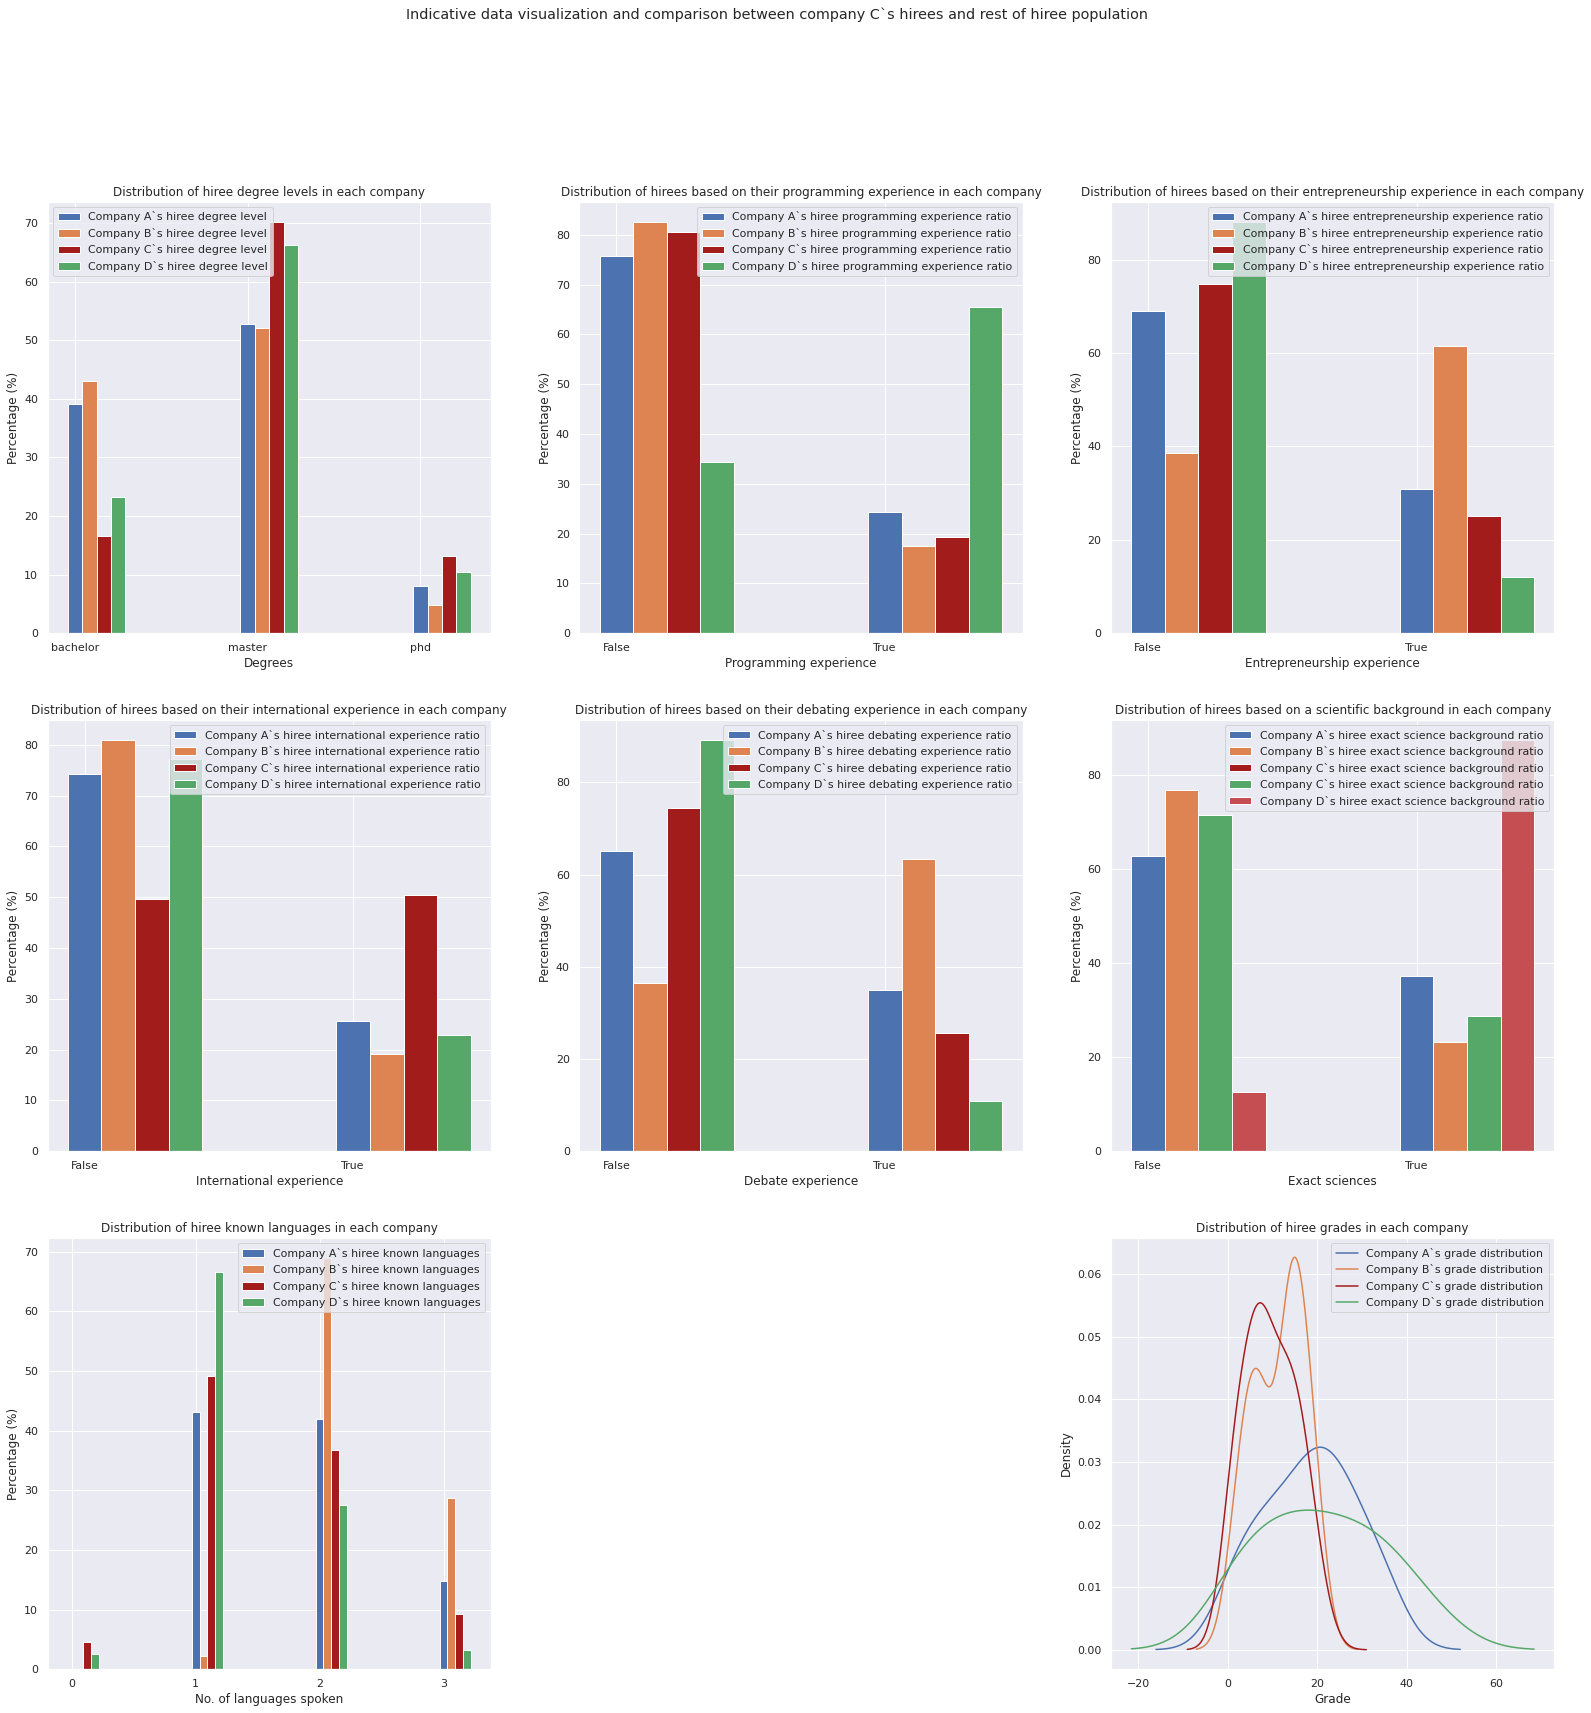

In [88]:
fig, axs = plt.subplots(3,3)
fig.suptitle('Indicative data visualization and comparison between company C`s hirees and rest of hiree population')
fig.set_figwidth(27)
fig.set_figheight(27)

#First plot
numberOfDegrees = recruitmentData['ind-degree'].unique().size
XDegreeAxis = np.arange(numberOfGenders)
for idx, x in enumerate(recruitmentData['company'].unique()):
    degreeColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-degree']
    normalizedDegreeCounts = degreeColumn.value_counts().sort_index().divide(degreeColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 0].bar(XDegreeAxis + idx/(numberOfDegrees * 4), normalizedDegreeCounts, width= 1/(numberOfDegrees * 4), label='Company ' + str(x) + '`s hiree degree level',color='#a31c1c')
    else: axs[0, 0].bar(XDegreeAxis + idx/(numberOfDegrees * 4), normalizedDegreeCounts, width= 1/(numberOfDegrees * 4), label='Company ' + str(x) + '`s hiree degree level')

axs[0, 0].set_xticks(XDegreeAxis)
axs[0, 0].set_xticklabels(recruitmentData['ind-degree'].sort_values().unique().tolist())
axs[0, 0].set_xlabel('Degrees')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].set_title('Distribution of hiree degree levels in each company')
axs[0, 0].legend()

#Second plot
XBooleanAxis = np.arange(2)
for idx, x in enumerate(recruitmentData['company'].unique()):
    progColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-programming_exp']
    normalizedProgCounts = progColumn.value_counts().sort_index().divide(progColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 1].bar(XBooleanAxis + idx/8, normalizedProgCounts, width= 1/8, label='Company ' + str(x) + '`s hiree programming experience ratio',color='#a31c1c')
    else: axs[0, 1].bar(XBooleanAxis + idx/8, normalizedProgCounts, width= 1/8, label='Company ' + str(x) + '`s hiree programming experience ratio')

axs[0, 1].set_xticks(XBooleanAxis)
axs[0, 1].set_xticklabels(recruitmentData['ind-programming_exp'].sort_values().unique().tolist())
axs[0, 1].set_xlabel('Programming experience')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].set_title('Distribution of hirees based on their programming experience in each company')
axs[0, 1].legend()

#Third plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    entrepreneurColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-entrepeneur_exp']
    normalizedEntrCounts = entrepreneurColumn.value_counts().sort_index().divide(entrepreneurColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 2].bar(XBooleanAxis + idx/8, normalizedEntrCounts, width= 1/8, label='Company ' + str(x) + '`s hiree entrepreneurship experience ratio', color='#a31c1c')
    else: axs[0, 2].bar(XBooleanAxis + idx/8, normalizedEntrCounts, width= 1/8, label='Company ' + str(x) + '`s hiree entrepreneurship experience ratio')

axs[0, 2].set_xticks(XBooleanAxis)
axs[0, 2].set_xticklabels(recruitmentData['ind-entrepeneur_exp'].sort_values().unique().tolist())
axs[0, 2].set_xlabel('Entrepreneurship experience')
axs[0, 2].set_ylabel('Percentage (%)')
axs[0, 2].set_title('Distribution of hirees based on their entrepreneurship experience in each company')
axs[0, 2].legend()

#Fourth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    internationalColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-international_exp']
    normalizedInterCounts = internationalColumn.value_counts().sort_index().divide(internationalColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 0].bar(XBooleanAxis + idx/8, normalizedInterCounts, width= 1/8, label='Company ' + str(x) + '`s hiree international experience ratio', color='#a31c1c')
    else: axs[1, 0].bar(XBooleanAxis + idx/8, normalizedInterCounts, width= 1/8, label='Company ' + str(x) + '`s hiree international experience ratio')

axs[1, 0].set_xticks(XBooleanAxis)
axs[1, 0].set_xticklabels(recruitmentData['ind-international_exp'].sort_values().unique().tolist())
axs[1, 0].set_xlabel('International experience')
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].set_title('Distribution of hirees based on their international experience in each company')
axs[1, 0].legend()

#Fifth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    debateColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-debateclub']
    normalizedDebateCounts = debateColumn.value_counts().sort_index().divide(debateColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 1].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree debating experience ratio', color='#a31c1c')
    else: axs[1, 1].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree debating experience ratio')

axs[1, 1].set_xticks(XBooleanAxis)
axs[1, 1].set_xticklabels(recruitmentData['ind-debateclub'].sort_values().unique().tolist())
axs[1, 1].set_xlabel('Debate experience')
axs[1, 1].set_ylabel('Percentage (%)')
axs[1, 1].set_title('Distribution of hirees based on their debating experience in each company')
axs[1, 1].legend()

#Sixth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    debateColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-exact_study']
    normalizedDebateCounts = debateColumn.value_counts().sort_index().divide(debateColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 2].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree exact science background ratio', color='#a31c1c')
    axs[1, 2].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree exact science background ratio')

axs[1, 2].set_xticks(XBooleanAxis)
axs[1, 2].set_xticklabels(recruitmentData['ind-exact_study'].sort_values().unique().tolist())
axs[1, 2].set_xlabel('Exact sciences')
axs[1, 2].set_ylabel('Percentage (%)')
axs[1, 2].set_title('Distribution of hirees based on a scientific background in each company')
axs[1, 2].legend()

#Seventh plot
numberOfLanguages = recruitmentData['ind-languages'].unique().size
XLanguagesAxis = np.arange(0,numberOfLanguages)
for idx, x in enumerate(recruitmentData['company'].unique()):
    languageColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-languages']
    normalizedLanguageCounts = languageColumn.value_counts().sort_index().divide(languageColumn.count()).multiply(100)
    if(normalizedLanguageCounts.index[0] != 0): normalizedLanguageCounts = pd.Series([0]).append(normalizedLanguageCounts)
    if (x == 'C'): axs[2, 0].bar(XLanguagesAxis + idx/(numberOfLanguages*4), normalizedLanguageCounts, width= 1/(numberOfLanguages * 4), label='Company ' + str(x) + '`s hiree known languages', color='#a31c1c')
    else: axs[2, 0].bar(XLanguagesAxis + idx/(numberOfLanguages*4), normalizedLanguageCounts, width= 1/(numberOfLanguages * 4), label='Company ' + str(x) + '`s hiree known languages')

axs[2, 0].set_xticks(XLanguagesAxis)
axs[2, 0].set_xticklabels(recruitmentData['ind-languages'].sort_values().unique().tolist())
axs[2, 0].set_xlabel('No. of languages spoken')
axs[2, 0].set_ylabel('Percentage (%)')
axs[2, 0].set_title('Distribution of hiree known languages in each company')
axs[2, 0].legend()

axs[2, 1].set_visible(False)

#Eigth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    gradeColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-university_grade']
    if (x == 'C'): axs[2, 2] = gradeColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s grade distribution', color='#a31c1c')
    else: axs[2, 2] = gradeColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s grade distribution')
axs[2, 2].set_xlabel('Grade')
axs[2, 2].set_ylabel('Density')
axs[2, 2].set_title('Distribution of hiree grades in each company')
axs[2, 2].legend()

#### Indicator analysis based on the plots above:

- In the first graph we can observe that for our company, the majority of the hirees have finished a masters degree (70% of the candidates) but this is the case for all the other companies as well.

- Based on the second, third, fifth and sixth graphs we can conclude that the majority of company C's hirees do not have any programming experience, any entrepreneurship experience, any debate experience and the majority also does not come from a scientific background.

- One thing to note (based on the fourth graph) is that the hirees of our company are evenly distributed between people that have had international experience and people that did not.

- Based on the eigth graph we can conclude that our company's hirees know around 2-3 other languages.

- Lastly, in terms of university grades, we can observe that the hirees of our company have an average of scores close to 62/100 with the maximum grade achieved being 77/100 and the lowest grade being 51/100.

### 1.5 Data cleaning and preparation as well as evaluating highest correlating parameters

In this section we will evaluate the features that we have visualized in the plotting above, make some assumptions and test them in terms of data meaningfulness.
These assumption will be used when building a model in the hopes of achieving a fair discrete alternative to our categorical data.

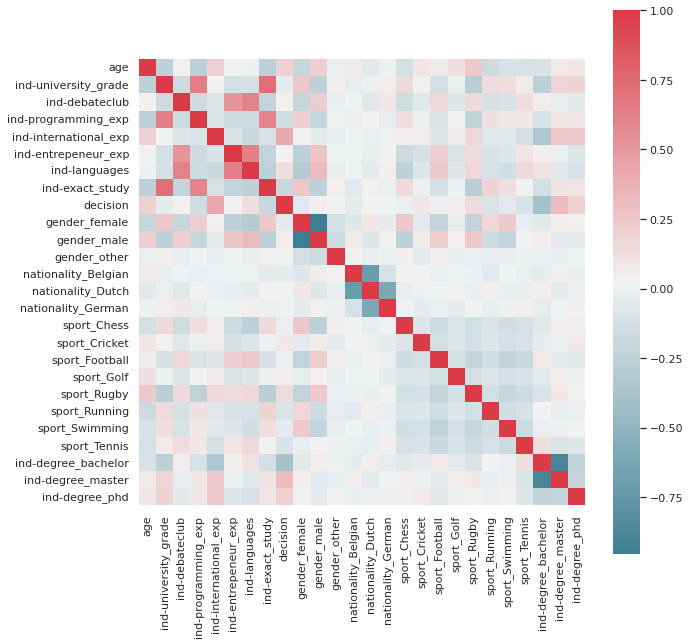

ind-degree_bachelor     -0.393112
ind-exact_study         -0.194558
ind-programming_exp     -0.159530
sport_Tennis            -0.106545
sport_Running           -0.094424
sport_Swimming          -0.049971
gender_female           -0.049927
ind-university_grade    -0.037285
nationality_Belgian     -0.032943
sport_Chess             -0.013728
sport_Football          -0.005183
nationality_German       0.011614
gender_other             0.016253
nationality_Dutch        0.017957
ind-entrepeneur_exp      0.027853
ind-debateclub           0.033267
gender_male              0.044885
sport_Golf               0.047959
sport_Cricket            0.077263
ind-languages            0.132866
sport_Rugby              0.144615
age                      0.194080
ind-degree_phd           0.202932
ind-degree_master        0.303153
ind-international_exp    0.406178
decision                 1.000000
Name: Ranking of the predictive power of indicators, dtype: float64


In [91]:
#Focus the dataset to our company
dataSet = recruitmentData.query("company == 'C'")
dataSetC = pd.DataFrame(dataSet, columns=[
    'age',
    'gender',
    'nationality',
    'sport',
    'ind-university_grade',
    'ind-debateclub',
    'ind-programming_exp',
    'ind-international_exp',
    'ind-entrepeneur_exp',
    'ind-languages',
    'ind-exact_study',
    'ind-degree',
    'decision'
])

labelEncoder = LabelEncoder()

# Convert the following numerical labels from interger to float
conversions = {
    'age' : float,
    'ind-languages' : float,
    'ind-university_grade' : float
}
dataSetC = dataSetC.astype(conversions)
    
# Label Encoder conversion
dataSetC['decision'] = labelEncoder.fit_transform(dataSetC['decision'])
dataSetC['ind-debateclub'] = labelEncoder.fit_transform(dataSetC['ind-debateclub'])
dataSetC['ind-entrepeneur_exp'] = labelEncoder.fit_transform(dataSetC['ind-entrepeneur_exp'])
dataSetC['ind-exact_study'] = labelEncoder.fit_transform(dataSetC['ind-exact_study'])
dataSetC['ind-programming_exp'] = labelEncoder.fit_transform(dataSetC['ind-programming_exp'])
dataSetC['ind-international_exp'] = labelEncoder.fit_transform(dataSetC['ind-international_exp'])    

# One Hot Encoding conversion for gender, sport and degree
dataSetC = pd.get_dummies(dataSetC)

# Scale our data 
scaler = StandardScaler()
dataSetCNew = pd.DataFrame(scaler.fit_transform(dataSetC), columns= dataSetC.columns)

# Evaluating correlations in order to potentially find good combinations of features
corr = dataSetCNew.corr()
plt.figure(figsize=(10,10))
seaborn.heatmap(corr, mask=np.zeros_like(corr), cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()            
ranking = corr['decision']
ranking = ranking.sort_values()
ranking.name = "Ranking of the predictive power of indicators"
print(ranking)






## 2. Models

### 2.1 Model 1: Neural Network with single hidden layer and no drop-out

In [90]:
# prepare configuration for cross validation test harness
from scikeras.wrappers import KerasClassifier

results = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy', 'test_precision', 'test_recall','features'])
names = []
models = []
inputChoices = [pd.DataFrame(dataSetCNew, columns=['ind-languages', 'ind-degree_phd', 'ind-degree_master', 'ind-international_exp']),
				dataSetCNew.filter(like='ind').sample(n=4,axis='columns'),
				dataSetCNew.filter(like='ind').sample(n=3,axis='columns'),
				dataSetCNew.filter(like='ind').sample(n=5,axis='columns')]
target = dataSetC['decision']

for sample in inputChoices:
	names.append("ANN with inputs: " + str(sample.columns))


#Setting hyperparameters and evaluation outputs
seed = 7
epochs = 100
scores = ['accuracy', 'precision', 'recall']

for idx, input in enumerate(inputChoices):	

	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	model = Sequential()

	#input layer
	model.add(Dense(6, kernel_initializer='uniform', activation = 'relu', input_dim = input.columns.size))

	#output layer
	model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))

	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	keras_clf = KerasClassifier(model = model, optimizer="adam", epochs=epochs, verbose=0)
	cv_results = model_selection.cross_validate(keras_clf, input, target, cv=kfold, scoring=scores)
	new_row = {'model': int(idx + 1), 
			'fit_time' : cv_results['fit_time'].mean(),
			'score_time' : cv_results['score_time'].mean(),
			'test_accuracy' : cv_results['test_accuracy'].mean(),
			'test_precision' : cv_results['test_precision'].mean(),
			'test_recall' : cv_results['test_recall'].mean(),
			'features' : ','.join(input.columns)}
	results = results.append(new_row, ignore_index=True)

print(results)

INFO:tensorflow:Assets written to: ram:///tmp/tmpc23tello/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpf2jmkl6x/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpe9r2egxt/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpbiom698b/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4bo3syw7/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpet_vu44x/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmplxxhamz4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpl6a585s4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmph4pmor8n/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpurp9xe2q/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpt3_9xixa/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpe4yhjx30/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpi3ccxep3/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp038wfg7t/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpvjyu66mj/assets
INFO:tensorflow:Assets wr

/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmp_6l2v5fj/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpom163rm7/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpq4mtv5ec/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpx_ezhvcy/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpi6hzwzf7/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpj32fdbzm/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmp1a_p705y/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmp9dhqdy6z/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpf0dj0rgl/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmp0bx1emf9/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp36lsmyf8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpm1h_3yup/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpdgzl38_u/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpbl9u6d87/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpcinjyuse/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp_byhzf1w/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxgpwvyni/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6qz8wr9g/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3paqk3mm/assets
  model  fit_time  score_time  test_accuracy  test_precision  test_recall  \
0     1  2.658564    0.065341          0.820        0.717076     0.494616   
1     2  2.645573    0.066322          0.834        0.811007     0.461931   
2     3  2.561545    0.063127          0.742        0.000000     0.000000   
3     4  2.971982    0.070201          0.7

In [89]:
#TODO plot returned results from the models

plottingFrame = results.drop(['model','features', 'fit_time', 'score_time'], axis=1)
print(plottingFrame)

XResultsAxis = np.arange(len(plottingFrame.columns))
# for idx, x in enumerate(results['model']):
#     row = plottingFrame.iloc[[idx]].values
#     print(row)
#     plt.bar(XResultsAxis + idx/(XResultsAxis * 4), row, width= 1/(XResultsAxis * 4), label='Model' + str(x) + ' results')

   test_accuracy  test_precision  test_recall
0          0.830        0.791464     0.454856
1          0.763        0.589286     0.377774
2          0.798        0.604324     0.629079
3          0.784        0.574660     0.591704


### 2.1 Model 3: Neural Network with single hidden layer and no drop-out on descriptors

In [94]:
# prepare configuration for cross validation test harness
from scikeras.wrappers import KerasClassifier

results = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy', 'test_precision', 'test_recall','features'])
names = []
models = []
inputChoices = [pd.DataFrame(dataSetCNew, columns=['sport_Tennis', 
												'sport_Running', 
												'sport_Swimming', 
												'sport_Chess',
												'sport_Football',
												'sport_Golf',
												'sport_Cricket',
												'sport_Rugby',
												'gender_female',
												'gender_other',
												'gender_male',
												'nationality_German',
												'nationality_Dutch',
												'nationality_Belgian',
												'age']),
				# dataSetCNew.filter(like='ind').sample(n=4,axis='columns'),
				# dataSetCNew.filter(like='ind').sample(n=3,axis='columns'),
				# dataSetCNew.filter(like='ind').sample(n=5,axis='columns')
				]
target = dataSetC['decision']

for sample in inputChoices:
	names.append("ANN with inputs: " + str(sample.columns))


#Setting hyperparameters and evaluation outputs
seed = 7
epochs = 100
scores = ['accuracy', 'precision', 'recall']

for idx, input in enumerate(inputChoices):	

	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	model = Sequential()

	#input layer
	model.add(Dense(6, kernel_initializer='uniform', activation = 'relu', input_dim = input.columns.size))

	#output layer
	model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))

	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	keras_clf = KerasClassifier(model = model, optimizer="adam", epochs=epochs, verbose=0)
	cv_results = model_selection.cross_validate(keras_clf, input, target, cv=kfold, scoring=scores)
	new_row = {'model': int(idx + 1), 
			'fit_time' : cv_results['fit_time'].mean(),
			'score_time' : cv_results['score_time'].mean(),
			'test_accuracy' : cv_results['test_accuracy'].mean(),
			'test_precision' : cv_results['test_precision'].mean(),
			'test_recall' : cv_results['test_recall'].mean(),
			'features' : ','.join(input.columns)}
	results = results.append(new_row, ignore_index=True)

print(results)

INFO:tensorflow:Assets written to: ram:///tmp/tmparvwc19f/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpaygdh2_7/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpemno0igu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmplb89v9zz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4hvcqzb0/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmph_5knc8o/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpaiqqo0rz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmplqw_j42g/assets


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmp0360ze00/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6f4y1p5l/assets
  model  fit_time  score_time  test_accuracy  test_precision  test_recall  \
0     1  2.913054    0.066998          0.739        0.423333     0.057489   

                                            features  
0  sport_Tennis,sport_Running,sport_Swimming,spor...  


### 1.6 Correlations between descriptors and correlations between descriptors and indicators

Firstly we will evaluate correlation between combinations of descriptors and then we will follow with descriptor-indicator combinations and evaluate the correlation of those as well in order to pick the features of interest for our models.

From a business perspective, hiring based on features such as nationality, sports or gender is considered a bad practice because these features do not add any meaning to the interest of a recruitor in terms of hiree professional capabilities.

Because of this, we will compute correlations and build a model based on other meaningful data, discarding the columns of sports, nationality and gender.

In [ ]:
degreeFrame['ind-languages'] = degreeFrame['ind-languages'].map(str)

bins= [0,25,27,29,32,100]
labels = ['21-25','25-27','27-29','29-32','32+']
degreeFrame['ageGroup'] = pd.cut(degreeFrame['age'], bins=bins, labels=labels, right=False)

x = pd.get_dummies(degreeFrame)
# print(x)
df = x
corr = df.corr()
seaborn.heatmap(corr, mask=np.zeros_like(corr), cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
            square=True)
            
ranking = corr['decision']
ranking = ranking.sort_values()
ranking.name = "Ranking of the predictive power of indicators"
print(ranking)


dataInScope = pd.DataFrame(df, columns=['ind-languages_2', 'ind-entrepeneur_exp', 'ind-debateclub', 'ageGroup_25-27'])
x = pd.DataFrame(dataInScope.values)
y = df['decision'].values

print(x)
#splitting dataset: training and test set, where 80% of the data is in the training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

#feature scaling
vsc = StandardScaler()
x_train = vsc.fit_transform(x_train)

print(x_train)
x_test = vsc.transform(x_test)

#initializing ANN
classifier2 = Sequential()

#adding the input layer and hidden layer
#TODO : try diff activation
classifier2.add(Dense(6, kernel_initializer='uniform', activation = 'relu', input_dim = 4))
#output layer
classifier2.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))

classifier2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
classifier2.fit(x_train, y_train, validation_split=0.33, epochs=150)


score = classifier2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
